In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !unzip drive/My\ Drive/tiny-imagenet-200

In [0]:
import os

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras_preprocessing import image


Using TensorFlow backend.


#### Data Pipeline image-net

In [0]:
train_img_gen = image.ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.4,
    zoom_range = 0.3,
    horizontal_flip = True
)

# we don't need to do augmentation for test data
test_img_gen = image.ImageDataGenerator(
    rescale = 1/255.0
)

In [23]:
train_gen = train_img_gen.flow_from_directory(
    'tiny-imagenet-200/train/',
    target_size = ((224, 224)),
    batch_size = 1024,
    class_mode = 'categorical'

)
test_gen = test_img_gen.flow_from_directory(
    'tiny-imagenet-200/test/',
    target_size = ((224, 224)),
    batch_size = 512,
    class_mode = 'categorical'

)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 1 classes.


In [7]:
for (x, y) in train_gen:
  print(x.shape, y.shape)
  break

(512, 224, 224, 3) (512, 200)


In [0]:
# validation data processing, since it is different form

class_ids = train_gen.class_indices

def load_validation_data(target_size, number_of_classes):
  with open('tiny-imagenet-200/val/val_annotations.txt') as f:
    lines = f.readlines()
    m = len(lines)
    X = np.empty((m, *target_size, 3))
    Y = np.empty(m)
    
    for i, line in enumerate(lines):
      token = line.split()
      img_name = token[0]
      img_label = token[1]
      
      img_url = os.path.join('tiny-imagenet-200/val/images', img_name)
      
      img = image.load_img(img_url)
      img = img.resize(target_size)
      X[i, ] = np.array(img, dtype=np.float32)/255.0
      img.close()
      Y[i] = class_ids[img_label]
      
    return X, keras.utils.np_utils.to_categorical(Y)
      
    

In [0]:
x_val, y_val =  load_validation_data((224, 224), 200)

In [10]:
print(x_val.shape, y_val.shape)

(10000, 224, 224, 3) (10000, 200)


### alex-net architecture

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=0.5, patience=5)

In [0]:
def create_alex_net():
  np.random.seed(1000)

  # (3) Create a sequential model
  model = Sequential()

  # 1st Convolutional Layer
  model.add(Conv2D(filters=96, input_shape=(224, 224, 3), kernel_size=(11,11),strides=(4,4), padding='valid'))
  model.add(Activation('relu'))
  # Pooling 
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  # Batch Normalisation before passing it to the next layer
  model.add(BatchNormalization())

  # 2nd Convolutional Layer
  model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))
  # Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  # Batch Normalisation
  model.add(BatchNormalization())

  # 3rd Convolutional Layer
  model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))
  # Batch Normalisation
  model.add(BatchNormalization())

  # 4th Convolutional Layer
  model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))
  # Batch Normalisation
  model.add(BatchNormalization())

  # 5th Convolutional Layer
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))
  # Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  # Batch Normalisation
  model.add(BatchNormalization())

  # Passing it to a dense layer
  model.add(Flatten())
  # 1st Dense Layer
  model.add(Dense(4096, input_shape=(224*224*3,)))
  model.add(Activation('relu'))
  # Add Dropout to prevent overfitting
  model.add(Dropout(0.4))
  # Batch Normalisation
  model.add(BatchNormalization())

  # 2nd Dense Layer
  model.add(Dense(4096))
  model.add(Activation('relu'))
  # Add Dropout
  model.add(Dropout(0.4))
  # Batch Normalisation
  model.add(BatchNormalization())

  # 3rd Dense Layer
  model.add(Dense(1000))
  model.add(Activation('relu'))
  # Add Dropout
  model.add(Dropout(0.4))
  # Batch Normalisation
  model.add(BatchNormalization())

  # Output Layer
  model.add(Dense(200))
  model.add(Activation('softmax'))

  return model


In [0]:
model = create_alex_net()

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_19 (Activation)   (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_20 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 256)         0         
__________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
hist = model.fit_generator(train_gen, steps_per_epoch = 100000//1024, validation_data=(x_val, y_val), validation_steps= 10000//1024, epochs=100)

Epoch 1/100
59/97 [=================>............] - ETA: 7:27 - loss: 3.6996 - acc: 0.1874

KeyboardInterrupt: ignored

In [0]:


def plot_loss_accuracy():
  # plot loss
  print("training_loss =", hist.history['loss'][-1],  "   val_loss =", hist.history['val_loss'][-1])
  print("training_acc =", hist.history['acc'][-1]*100, "   val_acc =", hist.history['val_acc'][-1]*100)
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.plot(hist.history['loss'], label='training_loss')

  # plot accuracy
  plt.plot(hist.history['val_acc'], label='val_acc')
  plt.plot(hist.history['acc'], label='training_acc')
  plt.legend()
  plt.show()



training_loss = 3.7227997037534224    val_loss = 3.72690825881958
training_acc = 18.36303750259607    val_acc = 18.239999985694887


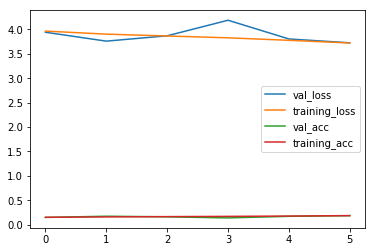

In [30]:
plot_loss_accuracy()